returning to this approach after some delay working on neural network approaches

#### Online, we import the usual packages. **xgboost** needs to be installed (with conda install xgboost or pip install -U xgboost).

In [6]:
#!pip install xgboost

  Using cached https://files.pythonhosted.org/packages/96/84/4e2cae6247f397f83d8adc5c2a2a0c5d7d790a14a4c7400ff6574586f589/xgboost-0.90.tar.gz
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /Users/jjaskolkambp/Library/Caches/pip/wheels/e9/48/4d/de4187b5270dff71d3697c5a7857a1e2d9a0c63a28b3462eeb
Successfully built xgboost
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### now the usual imports

In [1]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from collections import Counter
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
import random as rn

from IPython.display import clear_output

### load helper functions

In [84]:
def thresholding_analysis(preds, targets):
    admission_thresholds = [0.01, 0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    i = 0
    for thresh in admission_thresholds:
        thresholded_predictions = [0 if prob[0] >= thresh else 1 for prob in preds]
        
        f1_w, f1, acc, prec, rec,= get_metrics(targets,thresholded_predictions, print_output = False)

        if i == 0:
            output_df = pd.DataFrame([thresh, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
            output_df.columns = ['admission_threshold', 'weighted f1', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']
        else:
            output_df.loc[len(output_df)] = [thresh, f1_w, f1, acc, prec, rec, rec[0], rec[1]]
        i+=1
    
    return output_df

In [78]:
def show_confusion_matrix(targets, predictions, labels):
    LABELS = labels

    confusion_matrix = sklearn.metrics.confusion_matrix(targets, predictions)

    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 15});
    plt.title("Confusion matrix", fontsize=10)
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()

In [54]:
def get_metrics(y_test, preds, print_output = False):
    f1_w = sklearn.metrics.f1_score(y_test, preds, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, preds, average=None)
    acc = sklearn.metrics.accuracy_score(y_test, preds)
    prec = sklearn.metrics.precision_score(y_test,preds, average=None) 
    rec = sklearn.metrics.recall_score(y_test,preds, average=None)
    
    if print_output:
        print ('weighted f1: ', f1_w)
        print ('f1:          ', f1)
        print ('accuracy:    ', acc)
        print ('precision:   ', prec)
        print ('recall:      ', rec)
        print ('admission sens: ', rec[0])
        print ('admission spec: ', rec[1])
            
    return f1_w, f1, acc, prec, rec


In [55]:
def JJ_gridsearch(weights):
    epoch = 0
    for weight in weights:
        
        xgc = xgb.XGBClassifier(scale_pos_weight=weight)
        xgc.fit(X_train, y_train)
        preds = xgc.predict(X_test)
        f1_w, f1, acc, prec, rec = get_metrics(y_test, preds)
        
        if epoch == 0:
            results_df = pd.DataFrame([epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
            results_df.columns = ['trial number', 'class penalty', 'weighted f1', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']
        else:
            results_df.loc[len(results_df)] = [epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]
        
        epoch +=1
        
    return results_df, preds

In [47]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/combo'
model_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage/models'

#embeds = pd.read_csv(data_path + '/subjnote_embeds.csv', index_col = 0,low_memory = False)
#clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [103]:
medhx = np.load(data_path + '/medhx_embeds.npy')

In [25]:
target = np.load(data_path + '/admit_dc_target.npy')

In [29]:
features = np.load(data_path + '/subj_emeds.npy')

#### sanity checking the outcome variables

In [28]:
Counter(target)

Counter({1.0: 149218, 0.0: 16215})

### This array is an array of 768 element vectors for each entry into subjective notes

In [164]:
#X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1)

In [149]:
LABELS = ['admit', 'discharge'] 

#### first we are going to train xgb without class penalties

In [40]:
xgc = xgb.XGBClassifier()

%time xgc.fit(X_train, y_train)

CPU times: user 41 s, sys: 160 ms, total: 41.1 s
Wall time: 41.9 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [48]:
preds = xgc.predict(X_test)

predictions = xgc.predict_proba(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [58]:
f1_w, f1, acc, prec, rec = get_metrics(y_test, preds, print_output=True)

weighted f1:  0.8569071659474592
f1:           [0.01361206 0.94837413]
accuracy:     0.9018835078217559
precision:    [0.41791045 0.9026688 ]
recall:       [0.00691871 0.99895476]
admission sens:  0.006918705213738572
admission spec:  0.9989547598627787


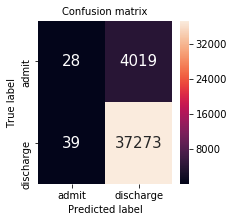

In [72]:
show_confusion_matrix(y_test, preds, LABELS)

In [85]:
thresholding_analysis(predictions, y_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

,admission_threshold,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,0.01,0.018563,"[0.1783487208866756, 0.0012320878532208384]",0.0984066,"[0.09790497387265337, 1.0]","[1.0, 0.0006164236706689537]",1,0.000616424
1,0.05,0.341518,"[0.20795255425259468, 0.35600464677903687]",0.28961,"[0.11670902929072864, 0.9771387318012272]","[0.9530516431924883, 0.2176511578044597]",0.953052,0.217651
2,0.1,0.710536,"[0.26323276919303407, 0.7590521874448526]",0.636863,"[0.16421838658342514, 0.9454857919347748]","[0.662960217445021, 0.6340319468267581]",0.66296,0.634032
3,0.2,0.86172,"[0.21956326652707148, 0.9313710016835016]",0.873836,"[0.27813565744600227, 0.9144369834710744]","[0.18136891524586113, 0.9489440394511149]",0.181369,0.948944
4,0.3,0.862452,"[0.10046237915090374, 0.9451000513083633]",0.896516,"[0.3361462728551336, 0.9063176540051171]","[0.059056090931554235, 0.9873499142367067]",0.0590561,0.98735
5,0.4,0.858771,"[0.037620503174229956, 0.9478366150512968]",0.901037,"[0.3883495145631068, 0.9036036254951036]","[0.019767729182110207, 0.9966230703259005]",0.0197677,0.996623
6,0.5,0.856907,"[0.013612056392805057, 0.9483741285430767]",0.901884,"[0.417910447761194, 0.9026687978300881]","[0.006918705213738572, 0.9989547598627787]",0.00691871,0.998955
7,0.6,0.855976,"[0.002464875523786049, 0.9485513787010081]",0.902149,"[0.5, 0.9022467290623715]","[0.001235483073881888, 0.9998659948542024]",0.00123548,0.999866
8,0.7,0.855741,"[0.0, 0.948557918419748]",0.902149,"[0.0, 0.9021494716990256]","[0.0, 1.0]",0,1
9,0.8,0.855741,"[0.0, 0.948557918419748]",0.902149,"[0.0, 0.9021494716990256]","[0.0, 1.0]",0,1


#### now we are going to try with an empiric class penality

In [150]:
xgc = xgb.XGBClassifier(scale_pos_weight=1/9)

%time xgc.fit(X_train, y_train)

CPU times: user 11min 26s, sys: 4.21 s, total: 11min 30s
Wall time: 11min 45s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [151]:
preds = xgc.predict(X_test)
predictions = xgc.predict_proba(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [152]:
f1_w, f1, acc, prec, rec = get_metrics(y_test, preds, print_output=True)

weighted f1:  0.7358339767372062
f1:           [0.28169458 0.78509165]
accuracy:     0.669165115210716
precision:    [0.17884282 0.94824904]
recall:       [0.66296022 0.66983812]
admission sens:  0.662960217445021
admission spec:  0.6698381217838765


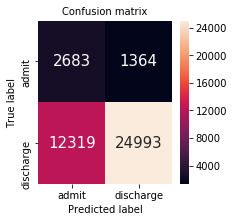

In [153]:
show_confusion_matrix(y_test, preds, LABELS)

In [154]:
thresholding_analysis(predictions, y_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,admission_threshold,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,0.01,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
1,0.05,0.0187091,"[0.17836051123843102, 0.0013926830574749584]",0.0984792,"[0.09791207993612852, 1.0]","[1.0, 0.0006968267581475129]",1,0.000696827
2,0.1,0.0499213,"[0.18067978533094814, 0.035738723090688984]",0.114099,"[0.09932879305681902, 0.9897959183673469]","[0.9982703236965653, 0.018197898799313893]",0.99827,0.0181979
3,0.2,0.200174,"[0.1940120923682102, 0.2008426628144938]",0.197442,"[0.10757755277897459, 0.9876864788065356]","[0.9871509760316284, 0.11178709262435678]",0.987151,0.111787
4,0.3,0.370156,"[0.21283177286160135, 0.3872202274730709]",0.310888,"[0.11980721393034825, 0.9789107511686053]","[0.9520632567333828, 0.24134326758147512]",0.952063,0.241343
5,0.4,0.559031,"[0.2428121648271806, 0.5933289974914058]",0.470853,"[0.1411731573865465, 0.9673998666909047]","[0.8670620212503088, 0.4278784305317324]",0.867062,0.427878
6,0.5,0.735834,"[0.2816945771431571, 0.7850916458559111]",0.669165,"[0.17884282095720572, 0.9482490420002276]","[0.662960217445021, 0.6698381217838765]",0.66296,0.669838
7,0.6,0.836772,"[0.2957351290684624, 0.8954544192374976]",0.817936,"[0.23792325056433408, 0.9289623782911793]","[0.3906597479614529, 0.8642795883361921]",0.39066,0.86428
8,0.7,0.864684,"[0.21349029589564109, 0.9353150512874189]",0.880461,"[0.2996873604287628, 0.9137014314928426]","[0.16580182851494935, 0.9579759862778731]",0.165802,0.957976
9,0.8,0.860009,"[0.05535224153705398, 0.9472851198529599]",0.900143,"[0.3723076923076923, 0.9043232441390067]","[0.029898690387941684, 0.994532590051458]",0.0298987,0.994533


### now we are going to repeat the process with medical history

#### first we are going to train xgb without class penalties

In [109]:
xgc = xgb.XGBClassifier()

%time xgc.fit(X_train[:10000], y_train[:10000])

CPU times: user 23.1 s, sys: 98.1 ms, total: 23.2 s
Wall time: 23.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [110]:
preds = xgc.predict(X_test)

predictions = xgc.predict_proba(X_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [111]:
f1_w, f1, acc, prec, rec = get_metrics(y_test, preds, print_output=True)

weighted f1:  0.8561186427784707
f1:           [0.01155235 0.94772348]
accuracy:     0.9006987596411905
precision:    [0.22222222 0.90247509]
recall:       [0.00593032 0.99774871]
admission sens:  0.005930318754633061
admission spec:  0.9977487135506004


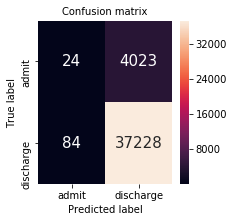

In [112]:
show_confusion_matrix(y_test, preds, LABELS)

In [113]:
thresholding_analysis(predictions, y_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

,admission_threshold,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,0.01,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
1,0.05,0.0913627,"[0.180915786103106, 0.08164939993845523]",0.134118,"[0.09968494013862633, 0.9453681710213777]","[0.9772671114405732, 0.042667238421955404]",0.977267,0.0426672
2,0.1,0.74188,"[0.268006148440931, 0.7932777278223931]",0.677603,"[0.17227750723410262, 0.9409341669731519]","[0.6031628366691376, 0.6856775300171527]",0.603163,0.685678
3,0.2,0.851644,"[0.2476538695917124, 0.9171553957027633]",0.850746,"[0.24434824434824434, 0.9185236955995807]","[0.2510501606127996, 0.9157911663807891]",0.25105,0.915791
4,0.3,0.862387,"[0.14682612695492178, 0.9399997412108743]",0.887884,"[0.28746397694524495, 0.9087338320282204]","[0.09859154929577464, 0.9734937821612349]",0.0985915,0.973494
5,0.4,0.858594,"[0.054812834224598934, 0.9457752780263327]",0.897435,"[0.2789115646258503, 0.9041008846962217]","[0.03039288361749444, 0.9914772727272727]",0.0303929,0.991477
6,0.5,0.856119,"[0.011552346570397111, 0.9477234830645469]",0.900699,"[0.2222222222222222, 0.902475091512933]","[0.005930318754633061, 0.9977487135506004]",0.00593032,0.997749
7,0.6,0.855955,"[0.004892367906066537, 0.9482640213658908]",0.901642,"[0.24390243902439024, 0.9022943995353114]","[0.002470966147763776, 0.9991691680960549]",0.00247097,0.999169
8,0.7,0.855713,"[0.0014752889107450208, 0.9483668357681402]",0.901811,"[0.15, 0.9021747018553908]","[0.0007412898443291327, 0.9995443825042881]",0.00074129,0.999544
9,0.8,0.855741,"[0.0, 0.948557918419748]",0.902149,"[0.0, 0.9021494716990256]","[0.0, 1.0]",0,1


#### now we are going to try with an empiric class penality

In [165]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(medhx, target, random_state=1)

In [170]:
set(y_train2 == y_train), set(y_test ==  y_test2)

({True}, {True})

In [171]:
xgc2 = xgb.XGBClassifier(scale_pos_weight=1/9)

%time xgc2.fit(X_train2, y_train)

CPU times: user 5min 12s, sys: 2.61 s, total: 5min 15s
Wall time: 5min 21s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [172]:
preds2 = xgc2.predict(X_test2)
predictions2 = xgc2.predict_proba(X_test2)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [173]:
f1_w, f1, acc, prec, rec = get_metrics(y_test, preds2, print_output=True)

weighted f1:  0.7382562301967925
f1:           [0.2735758  0.78865722]
accuracy:     0.6725742885466283
precision:    [0.17471737 0.94406666]
recall:       [0.63009637 0.6771816 ]
admission sens:  0.6300963676797627
admission spec:  0.6771816037735849


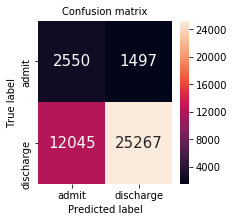

In [174]:
show_confusion_matrix(y_test, preds2, LABELS)

In [175]:
thresholding_analysis(predictions2, y_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

,admission_threshold,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,0.01,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
1,0.05,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
2,0.1,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
3,0.2,0.01793,"[0.17829764736981232, 0.0005358769626493757]",0.0980923,"[0.09787419284625988, 1.0]","[1.0, 0.00026801029159519727]",1,0.00026801
4,0.3,0.586613,"[0.23719123359964817, 0.6245129167268004]",0.496748,"[0.13924867679332156, 0.955242825607064]","[0.7996046454163578, 0.46389901372212694]",0.799605,0.463899
5,0.4,0.646507,"[0.2509383378016086, 0.6894122073435603]",0.560894,"[0.15060897118526587, 0.9525069703700203]","[0.7516679021497406, 0.5402015437392796]",0.751668,0.540202
6,0.5,0.738256,"[0.27357579658834885, 0.7886572195517821]",0.672574,"[0.1747173689619733, 0.9440666567030339]","[0.6300963676797627, 0.6771816037735849]",0.630096,0.677182
7,0.6,0.817183,"[0.28613091380427735, 0.8747833006508086]",0.786939,"[0.21284801735567072, 0.9310084084447402]","[0.4363726216950828, 0.8249624785591767]",0.436373,0.824962
8,0.7,0.860283,"[0.2519536513069253, 0.9262643433914153]",0.865761,"[0.277037037037037, 0.9180707666385847]","[0.231035334815913, 0.9346054888507719]",0.231035,0.934605
9,0.8,0.861893,"[0.08625921109666233, 0.9460206903615692]",0.898063,"[0.3509700176366843, 0.9056677779956854]","[0.049172226340499135, 0.9901372212692967]",0.0491722,0.990137


#### ensembling the two models

In [176]:
combined_predictions = (predictions + predictions2)/2

In [177]:
thresholding_analysis(combined_predictions, y_test)

/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

,admission_threshold,weighted f1,f1,accuracy,precision,recall,admission sensitivity,admission specificity
0,0.01,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
1,0.05,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
2,0.1,0.0174427,"[0.17825837994978638, 0.0]",0.0978505,"[0.09785052830097439, 0.0]","[1.0, 0.0]",1,0
3,0.2,0.0417239,"[0.1801821866856723, 0.02670615299188239]",0.110012,"[0.0990159600509155, 0.9960552268244576]","[0.9995058067704472, 0.013534519725557461]",0.999506,0.0135345
4,0.3,0.27055,"[0.20277763646538124, 0.27790065431757444]",0.242196,"[0.11302350639407945, 0.9899868680236376]","[0.984927106498641, 0.16163700686106347]",0.984927,0.161637
5,0.4,0.582627,"[0.25411563046816416, 0.618258247281367]",0.494983,"[0.14852229086658875, 0.9719013963109808]","[0.8791697553743514, 0.45331260720411665]",0.87917,0.453313
6,0.5,0.778934,"[0.3196874060715359, 0.8287456683261958]",0.726372,"[0.21123292024149984, 0.9517569775120781]","[0.657029898690388, 0.7338925814751286]",0.65703,0.733893
7,0.6,0.860575,"[0.33454066513006253, 0.9176301167008573]",0.853406,"[0.3009478672985782, 0.9304862928778068]","[0.3765752409191994, 0.9051243567753001]",0.376575,0.905124
8,0.7,0.870317,"[0.17939300212642567, 0.945257592365723]",0.897362,"[0.41207815275310833, 0.9109437526408669]","[0.1146528292562392, 0.982257718696398]",0.114653,0.982258
9,0.8,0.857355,"[0.016536964980544747, 0.9485535455308755]",0.902222,"[0.5230769230769231, 0.9028188114496053]","[0.008401284902396838, 0.9991691680960549]",0.00840128,0.999169


In [182]:
xgc2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.1111111111111111, seed=None,
       silent=None, subsample=1, verbosity=1)

In [178]:
import pickle

In [183]:
pickle.dump(xgc, open(data_path + "/subj_hx_xgb.pkl", "wb"))
pickle.dump(xgc2, open(data_path + "/medhx_xgb.pkl", "wb"))

In [188]:
with open(data_path + "/tabular_xgb.pkl", mode = 'rb') as pkl:
    xgc3 = pickle.load(pkl)

need to revisit this. gotta figure out how to get all three models trained and testing together.  probably easiest, just to do it all one more time (!) in a new notebook